# Bioinformatics Alignment `pandarallel` Examples with Controlled Number of Progress Bars

In the bioinformatics community, the `pandas` `DataFrame` is a popular tool for holding, manipulating, and performing computations on genomic sequence data and their associated properties.  For larger datasets, the need to parallelize operations on DataFrames motivates the need for tools such as `pandarallel`.  Because `pandarallel` is implemented against the standard Python `multiprocessing` library, this represents an opportunity for `dragon` to accelerate and enable greater scalability to users' code without necessarily requiring them to modify their code or patterns of thinking around their code.

The example proposed uses a variant of NPSR1 linked to moderate/severe (stage III/IV) endometriosis, asthma, and sleep-related disorders. This variant is queried against a small dataset of nucleotide and protein sequences for the closest match. The closeness of the match is determined by the pairwise alignment, the E-value, and the percentage of match coverage. 

In a multi-node `dragon` execution configuration (which is _not_ demonstrated here), some nodes may be slower/faster than others and it may be helpful to see the relative progress/speed of one cluster's nodes versus others -- this motivates showing more than just a single progress bar representing all workers.

The use case illustrates how parallel_apply from pandarallel is used for feature engineering for a k-means clustering use case. The features are commonly utilized in bioinformatics. 

In [1]:
!pip install pandarallel
!pip install biopython
!pip install pyalign
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import dragon
import multiprocessing

import cloudpickle

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import pandas as pd

import Bio
from Bio import SeqIO, Entrez
import pyalign
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import os.path
import pandarallel; pandarallel.__version__

'1.6.5'

The NPSR1 variant, rs142885915, is linked to stage III/IV endometriosis. The GenBank record is linked here: https://www.ncbi.nlm.nih.gov/nuccore/KR711722

In [4]:
Entrez.email = raise Exception("need to set your email address here")
handle = Entrez.efetch(db="nuccore", id="KR711722", rettype="gb", retmode="text")
read = SeqIO.read(handle, "genbank")
handle.close()

A subset of the nucleotide (DNA + mRNA) database is created that is specific to NPSR1. The database is written to a csv file. If the database exists, it is read from the file. 

In [5]:
if os.path.isfile("NSPR1_genes_database.csv"):
    handle = Entrez.esearch(db="nucleotide", term="npsr1[gene] AND mammals[ORGN]", retmax='100')
    record = Entrez.read(handle)
    nucl_identifiers = list(record["IdList"])
    handle.close()
    endo_name, endo_nucl_seq, endo_descr = str(read.name), str(read.seq), str(read.description)
    nucl_df = pd.read_csv("NSPR1_genes_database.csv", on_bad_lines='skip')
else:
    handle = Entrez.esearch(db="nucleotide", term="npsr1[gene] AND mammals[ORGN]", retmax='100')
    record = Entrez.read(handle)
    nucl_identifiers = list(record["IdList"])
    handle.close()
    endo_name, endo_nucl_seq, endo_descr = str(read.name), str(read.seq), str(read.description)
    nucl_id_names, nucl_sequences, nucl_descriptions = [endo_name], [endo_nucl_seq], [endo_descr]
    for idx, seq_id in enumerate(nucl_identifiers):
        try:
            handle = Entrez.efetch(db="nucleotide", id=seq_id,  retmode='text', rettype='gb')
            read = SeqIO.read(handle, "genbank")
            nucl_id_names.append(str(read.name))
            nucl_sequences.append(str(read.seq))
            nucl_descriptions.append(str(read.description))
            handle.close()
        except:
            pass
    nucl_df = pd.DataFrame(list(zip(nucl_id_names, nucl_sequences, nucl_descriptions)), columns=['ID Name','Sequence', 'Description'])
    nucl_df.to_csv("NSPR1_genes_database.csv", index=False)

In [6]:
nucl_df

,ID Name,Sequence,Description
0,KR711722,GTTCGTTGCAACAAATTGATGAGCAATGCTTTTTTATAATGCCAAC...,Synthetic construct Homo sapiens clone CCSBHm_...
1,XM_058724619,GGGGTGAAGAGGCTGTGTTGGCTACTGGATCATAACTGCTGAGGAG...,PREDICTED: Neofelis nebulosa neuropeptide S re...
2,NC_080785,ATGCCTGCCAACTGGACAGAGGGAAGCACCACTTCCAACCAGACCA...,PREDICTED: Ochotona princeps neuropeptide S re...
3,XM_012926142,ATGCCTGCCAACTGGACAGAGGGAAGCACCACTTCCAACCAGACCA...,PREDICTED: Ochotona princeps neuropeptide S re...
4,XM_004582374,GAACTCTTCACTGAGGTGGGCTCAGGGAGGGCTCTGTGCCTGCGTT...,Mus musculus neuropeptide S receptor 1 (Npsr1)...
...,...,...,...
65,XM_055293449,ATGCCAGCCAACCTCACAGAGGGCAGCCCTGAAGCCAGCACCACCT...,PREDICTED: Talpa occidentalis neuropeptide S r...
66,XM_055293447,ATGCCGGACAACCTCACCGAGGGCAGCCCCGAGGCCAACGGGACCG...,PREDICTED: Pteronotus parnellii mesoamericanus...
67,NC_072431,ATGCCGGACAACCTCACCGAGGGCAGCCCCGAGGCCAACGGGACCG...,PREDICTED: Pteronotus parnellii mesoamericanus...
68,XM_012932358,GGGATCTGTGACCCACATTCTCCAGAGGTAGTCCAAGGAGTGAGTG...,PREDICTED: Acinonyx jubatus neuropeptide S rec...


The use of a global variable inside a lambda function demonstrates key functionality from `cloudpickle` that is not otherwise available through `dill`. There is one progress bar for each worker. 

In [7]:
multiprocessing.set_start_method("dragon")
pandarallel.core.dill = cloudpickle
ctx = multiprocessing.get_context("dragon")
ctx.Manager = type("PMgr", (), {"Queue": ctx.Queue})
pandarallel.core.CONTEXT = ctx
pandarallel.pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


The pairwise alignment algorithm from PyAlign can be used for either nucleotide or amino acid sequences to find similar regions in two sequences. The pairwise alignment score can point to similar functions, evolutionary origins, and structural elements in the two sequences. The higher the score, the better the alignment.

In [8]:
def alignment_algorithm(sequence_1, sequence_2, gap):
    alignment = pyalign.global_alignment(sequence_1, sequence_2, gap_cost=gap, eq=1, ne=-1)
    return alignment.score

Running this next cell will cause as many progress bars to be displayed as there are workers.

In [9]:
start = time.monotonic()
nucl_df['PyAlign Alignment Score'] = nucl_df['Sequence'].parallel_apply(lambda seq2: alignment_algorithm(endo_nucl_seq, seq2, gap=0))
stop = time.monotonic()
functions, bar_num, tot_time = ['PyAlign Alignment Score'],[128],[stop-start]

Now we have our new column of values in our `pandas.DataFrame` that shows the pairwise alignment from PyAlign.

In [10]:
nucl_df.sort_values(by=['PyAlign Alignment Score'],  inplace = True, ascending=False)
nucl_df = nucl_df[['ID Name','Sequence', 'PyAlign Alignment Score', 'Description']]
nucl_df.head()

,ID Name,Sequence,PyAlign Alignment Score,Description
0,KR711722,GTTCGTTGCAACAAATTGATGAGCAATGCTTTTTTATAATGCCAAC...,1266.0,Synthetic construct Homo sapiens clone CCSBHm_...
31,XM_057550285,ATCCATGATGCTCGTTGAGAGGAGGGGTGCAAGGCAGGCACTGATC...,1266.0,PREDICTED: Monodelphis domestica neuropeptide ...
63,XM_055293451,GGCCACACTGGGCAGGTCTGTGGGATGGTGAGGGCTGTGCTGGCTG...,1266.0,PREDICTED: Mus musculus neuropeptide S recepto...
17,XM_032758339,ATGGCAGAAGGCAAAGTAGGAACAGGCACGCCACATGGCAAGAGAG...,1266.0,Homo sapiens neuropeptide S receptor 1 (NPSR1)...
62,NC_073231,GGCCACACTGGGCAGGTCTGTGGGATGGTGAGGGCTGTGCTGGCTG...,1264.0,PREDICTED: Mus musculus neuropeptide S recepto...


We can change our minds about how many progress bars to display, at will. 
This will be used to calculate the E-value or the expect value. 
The E value is used to determine the number of hits one can expect to see when searching the database. As the score increases, the E value decreases. This means there is a reduction in noise. 
The smaller the E-value, the better the match. The E value is calculated with using the Jaccard distance. 

In [11]:
pandarallel.pandarallel.initialize(progress_bar=10) 

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return 1.0 - float(intersection) / union

In [13]:
start = time.monotonic()
nucl_df['E Value'] = nucl_df['Sequence'].parallel_apply(lambda seq2: jaccard_similarity(list(endo_nucl_seq), list(seq2)))
stop = time.monotonic()
functions.append("E Value")
bar_num.append(10)
tot_time.append(stop-start)

/tmp/ipykernel_95639/183751692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nucl_df['E Value'] = nucl_df['Sequence'].parallel_apply(lambda seq2: jaccard_similarity(list(endo_nucl_seq), list(seq2)))


In [14]:
nucl_df.sort_values(by=['E Value'],  inplace = True, ascending=True)
nucl_df = nucl_df[['ID Name','Sequence', 'PyAlign Alignment Score','E Value', 'Description']]
nucl_df.head()

/tmp/ipykernel_95639/2651553576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nucl_df.sort_values(by=['E Value'],  inplace = True, ascending=True)


,ID Name,Sequence,PyAlign Alignment Score,E Value,Description
0,KR711722,GTTCGTTGCAACAAATTGATGAGCAATGCTTTTTTATAATGCCAAC...,1266.0,0.0,Synthetic construct Homo sapiens clone CCSBHm_...
56,XM_004045300,GGTAATTGCCAAGGAGAGAGCAGCACGTATATCCTCCCTGTCATCA...,1037.0,0.0,PREDICTED: Pongo pygmaeus neuropeptide S recep...
9,NW_026693761,GGTAATTGACAAGGAGAGAGCAGCACGTAGATCCTCCCTGTCATAA...,1036.0,0.0,PREDICTED: Hylobates moloch neuropeptide S rec...
24,NG_012185,ATGCCGGCCAACCTCACGGAGGGCAGCCCCAAGTCCAACGGGACTG...,1028.0,0.0,PREDICTED: Balaenoptera acutorostrata neuropep...
8,XM_046460636,ATGCCAGCCAACCTGACTGAGGGCAGCCCCAGTTCCAACGGGACCT...,1024.0,0.0,PREDICTED: Diceros bicornis minor neuropeptide...


There will be plenty of use cases / scenarios where a single progress bar is all we want. For this use case, we will use the sequencing coverage percentage which provides the percentage of coverage of the aligned sequence reads.

In [15]:
pandarallel.pandarallel.initialize(progress_bar=1)  # Will display 1 progress bar representing all workers.

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [16]:
start = time.monotonic()
nucl_df['Percentage Coverage'] = nucl_df['PyAlign Alignment Score'].parallel_apply(lambda match: 100*(float(match/len(endo_nucl_seq))))
stop = time.monotonic()
functions.append("Percentage Coverage")
bar_num.append(1)
tot_time.append(stop-start)

The final nucleotide dataframe output shows the alignment, E value, and percentage coverage ordered by percentage coverage and E value. The best matches line up with the query sequence.

In [17]:
nucl_df.sort_values(by=['Percentage Coverage'],  inplace = True, ascending=False)
nucl_df = nucl_df[['ID Name','Sequence', 'PyAlign Alignment Score','E Value', 'Percentage Coverage', 'Description']]
nucl_df

,ID Name,Sequence,PyAlign Alignment Score,E Value,Percentage Coverage,Description
0,KR711722,GTTCGTTGCAACAAATTGATGAGCAATGCTTTTTTATAATGCCAAC...,1266.0,0.0,100.000000,Synthetic construct Homo sapiens clone CCSBHm_...
31,XM_057550285,ATCCATGATGCTCGTTGAGAGGAGGGGTGCAAGGCAGGCACTGATC...,1266.0,0.0,100.000000,PREDICTED: Monodelphis domestica neuropeptide ...
63,XM_055293451,GGCCACACTGGGCAGGTCTGTGGGATGGTGAGGGCTGTGCTGGCTG...,1266.0,0.0,100.000000,PREDICTED: Mus musculus neuropeptide S recepto...
17,XM_032758339,ATGGCAGAAGGCAAAGTAGGAACAGGCACGCCACATGGCAAGAGAG...,1266.0,0.0,100.000000,Homo sapiens neuropeptide S receptor 1 (NPSR1)...
62,NC_073231,GGCCACACTGGGCAGGTCTGTGGGATGGTGAGGGCTGTGCTGGCTG...,1264.0,0.0,99.842022,PREDICTED: Mus musculus neuropeptide S recepto...
...,...,...,...,...,...,...
41,XM_057302845,ATGCCAGCCCACCTCGCAGAGGCCAGCCCCGACTCCAGCCACCCCA...,823.0,0.0,65.007899,PREDICTED: Nyctereutes procyonoides neuropepti...
2,NC_080785,ATGCCTGCCAACTGGACAGAGGGAAGCACCACTTCCAACCAGACCA...,820.0,0.0,64.770932,PREDICTED: Ochotona princeps neuropeptide S re...
34,NC_080070,ATGCCAGCCAACTTCACAGAGGGCAGCTTTCATGCCAACCAGACTG...,817.0,0.0,64.533965,PREDICTED: Psammomys obesus neuropeptide S rec...
32,XM_057550284,ATGACAGCCAACCTCACAGAAGATGCCTCCACTTCCAATATAACGT...,800.0,0.0,63.191153,PREDICTED: Sorex cinereus neuropeptide S recep...


In [18]:
nucl_df.dtypes

ID Name                     object
Sequence                    object
PyAlign Alignment Score    float64
E Value                    float64
Percentage Coverage        float64
Description                 object
dtype: object

Though it is very minor compared to the overall wall time, reducing the number of progress bars displayed can shave off a small amount of execution time. The time for the pandarallel parallel_apply for the respective applications is displayed in the pandas dataframe below.  

In [19]:
time_df = pd.DataFrame(list(zip(functions, bar_num, tot_time)), columns=['Pandarallel Function','Number of Bars', 'Time'])
time_sum = time_df['Time'].sum()
time_df.loc[len(time_df.index)] = ['Total Time for Dragon Multiprocessing Pandarallel Processes (Nucleotides)', "N/A", time_sum]
time_df

,Pandarallel Function,Number of Bars,Time
0,PyAlign Alignment Score,128,16.941219
1,E Value,10,9.061706
2,Percentage Coverage,1,7.536713
3,Total Time for Dragon Multiprocessing Pandaral...,N/A,33.539638


The correlation for the variables in the nucleotide pandas dataframe are plotted, and the variables for k-means clustering are identified.

/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/pytho

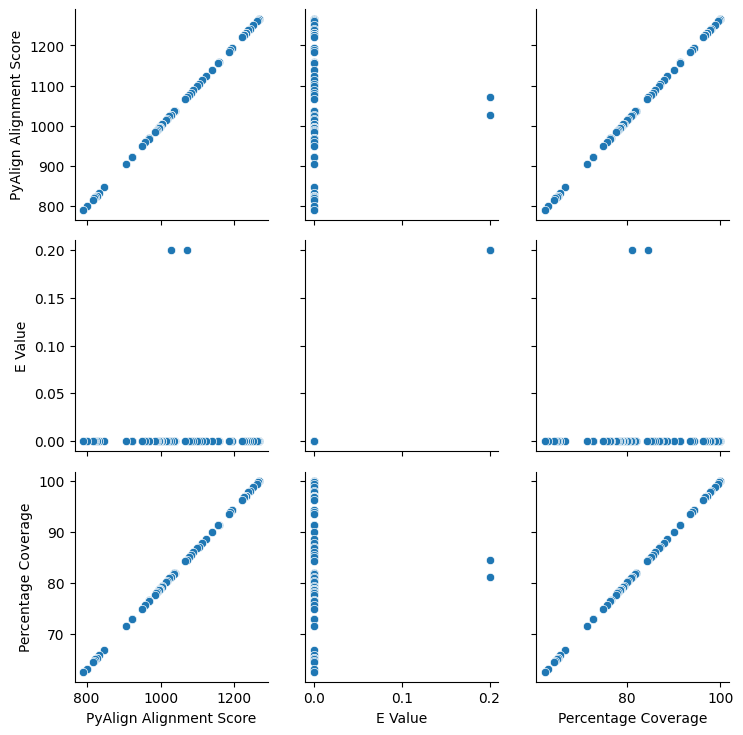

In [20]:
sns.PairGrid(nucl_df).map(sns.scatterplot);

The x-axis is the PyAlign Alignment Score, and the y-axis is percentage coverage. The scatterplot function from the seaborn library is used for k-means clustering using the variables identified.

/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='PyAlign Alignment Score', ylabel='Percentage Coverage'>

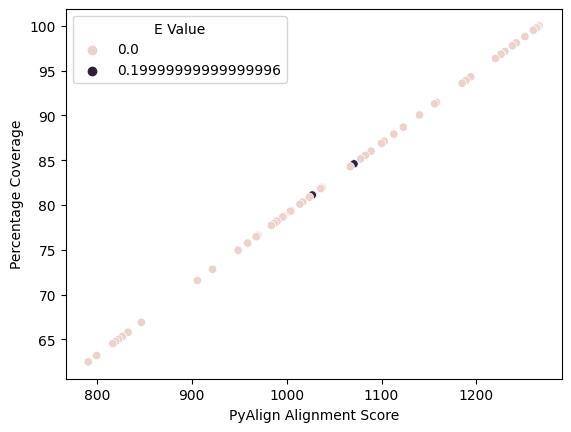

In [21]:
sns.scatterplot(data = nucl_df[['PyAlign Alignment Score', 'E Value', 'Percentage Coverage']], x = 'PyAlign Alignment Score', y = 'Percentage Coverage', hue = 'E Value')

The cluster number is determined from the elbow method and the default arguments for the k-means algorithm.

/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/cray/css/users/gho

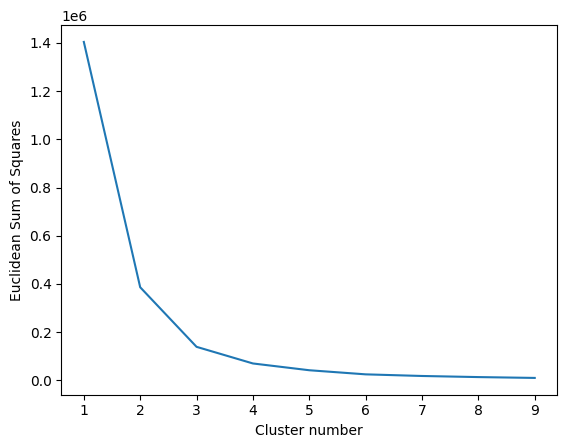

In [22]:
X = np.array(nucl_df.loc[:,['PyAlign Alignment Score', 'Percentage Coverage']])

euclidean = []
for i in range(1, 10):
    model = KMeans(n_clusters = i)
    model.fit(X)                              
    euclidean.append(model.inertia_)

plt.plot(range(1, 10), euclidean)
plt.xlabel('Cluster number')
plt.ylabel('Euclidean Sum of Squares')
plt.show()

The k-means algorithm is plotted, and the default arguments for the k-means algorithm is used. 

/cray/css/users/ghorakav/dragon_31032022/hpc-pe-dragon-dragon/_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


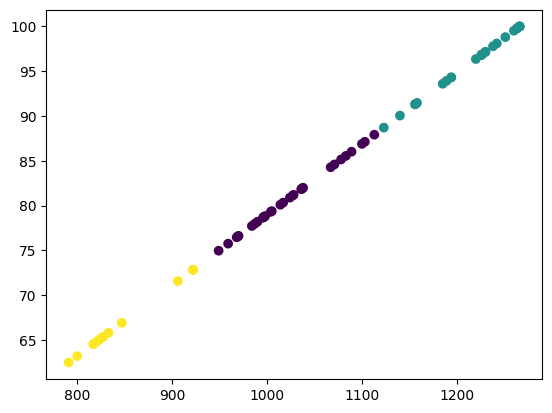

In [23]:
model = KMeans(n_clusters=3).fit(X)
plt.scatter(X[:,0], X[:,1], c=model.labels_.astype(float))